In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 

%matplotlib inline

Imagine we have a lot of small pieces of images, where we need to assemble them correctly to form a big real image. How do you arrange lots of scrambled image pieces into a big single image? How can you stitch a lot of natural images to a single image?

We are looking for specific patterns or specific features which are unique, which can be easily tracked, features which can be easily compared. 

Recognizing features in an image is inherent and easy to humans.

Given an image of a building and 2 patches from the image. Consider the first patch is of a flat surface and the second patch is a corner of a roof on the building. The flat surface is spread in many areas, so it's difficult to find the exact location of the first patch. But the corners of a building are easily found out because at corners wherever you move this patch it will look different. So the second patch can be considered a good feature.

So corners are good features. How do we find them? Look for the regions in an image which maximum variation when moved(by a small amount) in all region around it. Finding these image features is called **Feature Detection**.

Once the features are found, we need to find the same in the other images. We take a region around the feature, and search for the same area in other images. We take a region around the feature, we explain it in our own words, like “upper part is blue sky, lower part is building region, on that building there are some glasses etc” and you search for the same area in other images. Basically, you are describing the feature. Similar way, computer also should describe the region around the feature so that it can find it in other images. So called description is called Feature Description. Once you have the features and its description, you can find same features in all images, align them or stitch them.

### Harris Corner Detection

Corners are regions in the image with large vairation in intensity in all the directions. The Harris Corner Detection finds the difference in intensity for a displacement of (u, v) in all directions.

Window function is either a rectangular window or gaussian window which gives weights to pixels underneath.

We have to maximize this function for corner detection. That means, we have to maximize the second term in the equation. 

E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix}* M *\begin{bmatrix} u \\ v \end{bmatrix}
where

M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\
                                     I_x I_y & I_y I_y \end{bmatrix}

R = det(M) - k(trace(M))^2

So the values of these eigen values decide whether a region is corner, edge or flat.

- When |R| is small, which happens when \lambda_1 and \lambda_2 are small, the region is flat.
- When R<0, which happens when \lambda_1 >> \lambda_2 or vice versa, the region is edge.
- When R is large, which happens when \lambda_1 and \lambda_2 are large and \lambda_1 \sim \lambda_2, the region is a corner.

OpenCV has the function **cv2.cornerHarris()**. Its arguments are :

- img - Input image, it should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of Sobel derivative used.
- k - Harris detector free parameter in the equation.

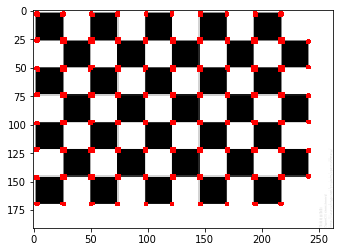

In [4]:
img = cv2.imread('images/chessboard.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

img[dst>0.01 * dst.max()] = [255, 0, 0]

plt.imshow(img)

##### Corner with Subpixel Accuracy

Sometimes, you may need to find the corners with maximum accuracy. OpenCV comes with a function cv2.cornerSubPix() which further refines the corners detected with sub-pixel accuracy. Below is an example. As usual, we need to find the harris corners first. Then we pass the centroids of these corners (There may be a bunch of pixels at a corner, we take their centroid) to refine them. Harris corners are marked in red pixels and refined corners are marked in green pixels. For this function, we have to define the criteria when to stop the iteration. We stop it after a specified number of iteration or a certain accuracy is achieved, whichever occurs first. We also need to define the size of neighbourhood it would search for corners.


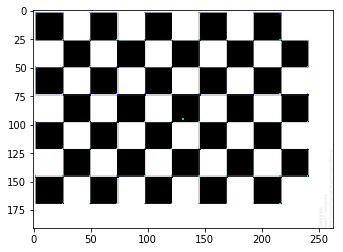

In [2]:
img = cv2.imread('images/chessboard.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
ret, dst = cv2.threshold(dst, 0.01*dst.max(), 255, 0)
dst = np.uint8(dst)

#find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

plt.imshow(img)

### Shi-Tomasi Corner Detector & Good Features to Track

Scoring function in Shi-Thomasi:

R = min(\lambda_1, \lambda_2)

If it is greater than a trashold value, it is considered as a corner.

**cv2.goodFeatureToTrack()** - It finds N strongest corners in the image by Shi-Tomasi method(Harris Corner Detection can al so be specified). Image should be a grayscale image. Specify number of corners you want to find. Specify quality level between 0-1, which denotes the minimum quality of corner below which everyone is rejected. We also provide minimum euclidean distance between corners detected. 

With this information, the function finds corners in the image. All corners below quality level are rejected. Then it sorts the remaining corners based on quality in descending order. Then function takes first strongest corner, throws away all the nearby corners in the ranage of minimum distance and returns N strongest corners.

In [8]:
img = cv2.imread('images/simple.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 25, 0.01, 10)
corners = np.int0(corners)
corners

array([[[122, 142]],

       [[ 41, 145]],

       [[118, 162]],

       [[202,  86]],

       [[147, 140]],

       [[ 23,  92]],

       [[209, 178]],

       [[ 11, 202]],

       [[ 54, 201]],

       [[ 75, 128]],

       [[149, 161]],

       [[166, 187]],

       [[  9, 135]],

       [[174, 125]],

       [[130,  63]],

       [[ 74,  76]],

       [[146,  96]],

       [[131, 134]],

       [[ 24, 168]],

       [[ 66, 200]],

       [[ 45,  81]],

       [[102, 177]],

       [[131,  76]],

       [[177,  75]],

       [[172, 157]]], dtype=int64)

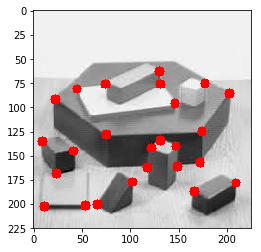

In [11]:
for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 4, 255, -1)
    
plt.imshow(img)

### Scale-Invariant Feature Transform

Harris corner detector is not good enough when scale of images changes. The above corner detectors are rotaion-invariant, which means, even if the image is rotated, we can find the same corners. It is obvous because corners remain corners in rotated image also.

But a corner may not be a corner if the image is scaled. Harris corner is not scale invariant. A corner in a small image within a small window is flat when it is zoomed in the same window. 

4 steps of SIFT

#### 1. Scale-space Extrema Detection

We can’t use the same window to detect keypoints with different scale. It is OK with small corner. But to detect larger corners we need larger windows. For this, scale-space filtering is used. In it, Laplacian of Gaussian is found for the image with various \sigma values. LoG acts as a blob detector which detects blobs in various sizes due to change in \sigma. In short, \sigma acts as a scaling parameter. For eg, in the above image, gaussian kernel with low \sigma gives high value for small corner while guassian kernel with high \sigma fits well for larger corner. So, we can find the local maxima across the scale and space which gives us a list of (x,y,\sigma) values which means there is a potential keypoint at (x,y) at \sigma scale.

But this LoG is a little costly, so SIFT algorithm uses Difference of Gaussians which is an approximation of LoG. Difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different \sigma, let it be \sigma and k\sigma. This process is done for different octaves of the image in Gaussian Pyramid. It is represented in below image:

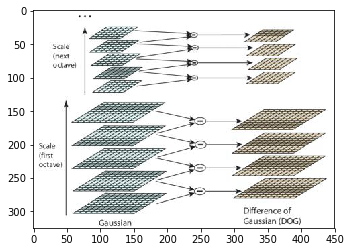

In [13]:
img = cv2.imread('images/sift_dog.jpg')
plt.imshow(img);

Difference of Gaussian
Once this DoG are found, images are searched for local extrema over scale and space. For eg, one pixel in an image is compared with its 8 neighbours as well as 9 pixels in next scale and 9 pixels in previous scales. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale. It is shown in below image:

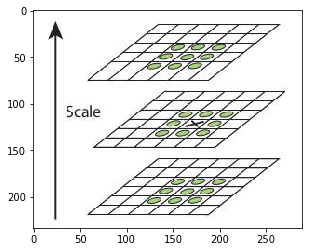

In [14]:
img = cv2.imread('images/sift_local_extrema.jpg')
plt.imshow(img);

Regarding different parameters, the paper gives some empirical data which can be summarized as, number of octaves = 4, number of scale levels = 5, initial \sigma=1.6, k=\sqrt{2} etc as optimal values.

#### 2. Keypoint Localization
Once potential keypoints locations are found, they have to be refined to get more accurate results. They used Taylor series expansion of scale space to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. This threshold is called contrastThreshold in OpenCV

DoG has higher response for edges, so edges also need to be removed. For this, a concept similar to Harris corner detector is used. They used a 2x2 Hessian matrix (H) to compute the pricipal curvature. We know from Harris corner detector that for edges, one eigen value is larger than the other. So here they used a simple function,

If this ratio is greater than a threshold, called edgeThreshold in OpenCV, that keypoint is discarded. It is given as 10 in paper.

So it eliminates any low-contrast keypoints and edge keypoints and what remains is strong interest points.

#### 3. Orientation Assignment
Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neigbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region. An orientation histogram with 36 bins covering 360 degrees is created. (It is weighted by gradient magnitude and gaussian-weighted circular window with \sigma equal to 1.5 times the scale of keypoint. The highest peak in the histogram is taken and any peak above 80% of it is also considered to calculate the orientation. It creates keypoints with same location and scale, but different directions. It contribute to stability of matching.

####4. Keypoint Descriptor
Now keypoint descriptor is created. A 16x16 neighbourhood around the keypoint is taken. It is devided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available. It is represented as a vector to form keypoint descriptor. In addition to this, several measures are taken to achieve robustness against illumination changes, rotation etc.

#### 5. Keypoint Matching
Keypoints between two images are matched by identifying their nearest neighbours. But in some cases, the second closest-match may be very near to the first. It may happen due to noise or some other reasons. In that case, ratio of closest-distance to second-closest distance is taken. If it is greater than 0.8, they are rejected. It eliminaters around 90% of false matches while discards only 5% correct matches, as per the paper.

This algorithm is patented. So this algorithm is included in Non-free module in OpenCV.

Let’s start with keypoint detection and draw them. First we have to construct a SIFT object. We can pass different parameters to it which are optional 

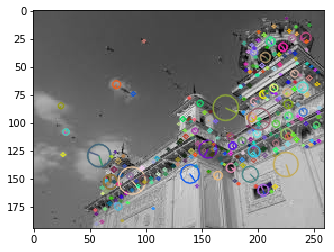

In [27]:
img = cv2.imread('images/home.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

img = cv2.drawKeypoints(gray, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

**sift.detect()** function finds the keypoint in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.

OpenCV also provides cv2.drawKeyPoints() function which draws the small circles on the locations of keypoints. If you pass a flag, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to it, it will draw a circle with size of keypoint and it will even show its orientation

Now to calculate the descriptor, OpenCV provides two methods.

1. Since you already found keypoints, you can call **sift.compute()** which computes the descriptors from the keypoints we have found. Eg: kp,des = sift.compute(gray,kp)
2. If you didn’t find keypoints, directly find keypoints and descriptors in a single step with the function, **sift.detectAndCompute()**.

In [28]:
img = cv2.imread('images/home.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
# kp = sift.detectAndCompute(gray,None)
kp = sift.compute(gray, kp)
img = cv2.drawKeypoints(gray, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

TypeError: Expected cv::KeyPoint for argument 'keypoints'

Here kp will be a list of keypoints and des is a numpy array of shape Number\_of\_Keypoints * 128.

So we got keypoints, descriptors etc. Now we want to see how to match keypoints in different images.